**First clone the github repository**

In [1]:
#%cd /content
#! git clone https://github.com/Tikquuss/lwd
#%cd lwd/scripts

# **Set-up** 
*Once this section is configured, you can comment (optionally) the previous cell and run everything at once (Runtime -> Run all).*

* Uncomment the line corresponding to your function, and choose the values of the bounds of the intervals in which the learning and test data will be generated (uniformly) : we have at the end of each line the corresponding values taken from the ["Sobolev Training"](https://arxiv.org/abs/1706.04859) original paper (page 14-15)
* The steps are used for the curves: they can therefore be chosen according to the desired precision.

In [2]:
f_name = "Styblinski-Tang" # https://www.sfu.ca/~ssurjano/stybtang.html (-5, 5), (-5, 5)
#f_name = "Ackley" # http://www.sfu.ca/~ssurjano/ackley.html (-5, 5), (-5, 5)
#f_name = "Beale" # https://www.sfu.ca/~ssurjano/beale.html (-4.5, 4.5), (-4.5, 4.5)
#f_name = "Booth" # https://www.sfu.ca/~ssurjano/booth.html (-10, 10), (-10, 10)
#f_name = "Bukin" # https://www.sfu.ca/~ssurjano/bukin6.html (-15, -5), (-3, 3)
#f_name = "McCormick" # https://www.sfu.ca/~ssurjano/mccorm.html (-1.5, 4), (-3, 4)
#f_name = "Rosenbrock" # https://www.sfu.ca/~ssurjano/rosen.html (-2, 2), (-2, 2)

(min_x, max_x), (min_y, max_y) = (-5, 5), (-5, 5) 
step_x, step_y = 0.25, 0.25

In [3]:
try:
    %tensorflow_version 1.x
    %matplotlib inline
except Exception:
    pass

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random

from utils import gradient, genData, plotFunction, plotGrad, get_data_loader, plot_stat
from utils import forward, backprop, MLP, Siren, train, test
from twin_net_tf import graph, Generator, get_diffML_data_loader, test as twin_net_tf_test 
from twin_net_tf_siren import test as twin_net_tf_test_siren
from functions import * # Styblinski-Tang (ST), Ackley, Beale, Booth, Bukin, McCormick, Rosenbrock

TensorFlow 1.x selected.
1.15.2
False


1.15.2
False


In [4]:
# Global
max_epoch = 2  # maximun number of epoch
batch_size = 1 # batch_size
nTrain = 25 # number of training examples
nTest = 25 # number of testexamples

learning_rate = 3e-5 # learning rate

learning_rate_schedule = [(0.0, 1.0e-8), (0.2, 0.1), (0.6, 0.01), (0.9, 1.0e-6), (1.0, 1.0e-8)]

improving_limit = float("inf") # Stop training if the training loss does not decrease n times (no limit here)
INPUT_DIM = 2 
HIDDEN_DIM = 20
N_HIDDEN = 2 # number of hidden layers
OUTPUT_DIM = 1

# hyperparameters in the different loss functions to express a tradeoff between y loss and dydx loss
loss_config = {'alpha': 1, "beta" : 1} # loss = alpha * loss_y + beta * loss_dydx

# twin_net
train_seed, test_seed = 0, 0

# MLP
activation_function = F.softplus
deriv_activation_function = torch.sigmoid # for twin_net_pytorch
mlp_model_kwargs = {"in_features" : INPUT_DIM, # depends on the function
                    "hidden_features" : HIDDEN_DIM, 
                    "hidden_layers" : N_HIDDEN, 
                    "out_features": OUTPUT_DIM, 
                    "activation_function" : activation_function, 
                    "deriv_activation_function" : deriv_activation_function,
                   }
# Siren
first_omega_0 = 30.
hidden_omega_0 = 30.
outermost_linear = True

siren_model_kwargs = {"in_features" : INPUT_DIM, 
                      "hidden_features" : HIDDEN_DIM, 
                      "hidden_layers" : N_HIDDEN, 
                      "out_features": OUTPUT_DIM, 
                      "outermost_linear" : outermost_linear, 
                      "first_omega_0" : first_omega_0, 
                      "hidden_omega_0" : hidden_omega_0}

# twin_net tf                
generator_kwargs = {"hidden_units" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN}

# **To avoid repeating the same code too much**

In [5]:
def run_train(name, model_class, model_kwargs, with_derivative, name_function, name_grad,  
              normalize = False, learning_rate_schedule = None):
    global x_train, y_train, dydx_train, x_test, y_test, dydx_test 
    global batch_size, learning_rate, max_epoch, improving_limit
    global min_x, max_x, step_x, min_y, max_y, step_y
    global loss_config

    if with_derivative :
        train_dataloader, config = get_data_loader(x = x_train, y = y_train,  dydx = dydx_train, 
                                                   batch_size = batch_size, normalize = normalize)
        test_dataloader, _ = get_data_loader(x = x_test, y = y_test,  dydx = dydx_test, batch_size = batch_size)
    else :
        train_dataloader, config = get_data_loader(x = x_train, y = y_train,  dydx = None, 
                                                   batch_size = batch_size, normalize = normalize)
        test_dataloader, _ = get_data_loader(x = x_test, y = y_test,  dydx = None, batch_size = batch_size)

    config["learning_rate_schedule"] = learning_rate_schedule
    config.update(loss_config)
     
    model = model_class(**model_kwargs)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    
    model, stats, best_loss = train(name, model, train_dataloader, optimizer, criterion, config, 
                                    with_derivative, max_epoch = max_epoch, improving_limit = improving_limit)
    
    plot_stat(stats, with_derivative = with_derivative)

    (test_loss, r_y, r_dydx), (x_list, y_list, dydx_list, y_pred_list, dydx_pred_list) = test(
        name, model, test_dataloader, criterion, config, with_derivative
    )

    x_mean, x_std = config.get("x_mean", 0.), config.get("x_std", 1.)
    y_mean, y_std = config.get("y_mean", 0.), config.get("y_std", 1.)
    dydx_mean, dydx_std = config.get("dydx_mean", 0.), config.get("dydx_std", 1.)

    def function(x):
        x = torch.tensor(x)
        x_scaled = (x-x_mean) / x_std
        y_pred_scaled = model(x = x_scaled.float())
        y_pred = y_mean + y_std * y_pred_scaled
        y_pred = y_pred.detach().squeeze().numpy()
        return y_pred

    def deriv_function(index):
        def f(x) :
            x = torch.tensor(x, requires_grad = True)
            x_scaled = (x-x_mean) / x_std
            if name == "net" :
                y_pred_scaled = model(x = x_scaled.float()) 
                dydx_pred_scaled = gradient(y_pred_scaled, x_scaled)
            elif name == "twin_net" :
                y_pred_scaled, zs = forward(net = model.net, x = x_scaled.float(), return_layers = True)
                dydx_pred_scaled = backprop(net = model.net, y = y_pred_scaled, zs = zs)
            dydx_pred = dydx_mean + dydx_std * dydx_pred_scaled
            dydx_pred = dydx_pred.detach().squeeze().numpy()
            return dydx_pred[index]
        return f

    plotFunction(name = name_function, function = function, 
                 min_x = min_x, max_x = max_x, step_x = step_x, 
                 min_y = min_y, max_y = max_y, step_y = step_y)

    plotGrad(name = name_grad, deriv_function = deriv_function, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)
    
    return model, test_loss, stats

def run_diffML_train(name, generator, generator_kwargs, name_function, name_grad, siren = False):
    global nTrain, nTest, train_seed, test_seed
    global min_x, max_x, step_x, min_y, max_y, step_y
    global max_epoch, improving_limit
    global first_omega_0, hidden_omega_0, outermost_linear
    if siren :
        loss, regressor, dtrain, dtest, dydxTest, values, deltas = twin_net_tf_test_siren(
              generator, [nTrain], 
              nTrain, nTest, 
              trainSeed = train_seed, testSeed = test_seed, weightSeed = 0, 
              deltidx=0,
              generator_kwargs = generator_kwargs,
              epochs = max_epoch,
              first_omega_0 = first_omega_0, 
              hidden_omega_0 = hidden_omega_0, 
              outermost_linear = outermost_linear,
              improving_limit = improving_limit
          )
    else :
        loss, regressor, dtrain, dtest, dydxTest, values, deltas = twin_net_tf_test(
              generator, [nTrain], 
              nTrain, nTest, 
              trainSeed = train_seed, testSeed = test_seed, weightSeed = 0, 
              deltidx=0,
              generator_kwargs = generator_kwargs,
              epochs = max_epoch,
              improving_limit = improving_limit
          )
    
    #plot_stat(regressor.regressor.stats["normal"], with_derivative = with_derivative)
    #plot_stat(regressor.stats["differential"], with_derivative = with_derivative)

    plotFunction(name = name_function, function =  lambda x : regressor.predict_values([x])[0][0], 
                 min_x = min_x, max_x = max_x, step_x = step_x, 
                 min_y = min_y, max_y = max_y, step_y = step_y)

    plotGrad(name = name_grad, 
            deriv_function = lambda index : lambda x : regressor.predict_values_and_derivs([x])[1][0][index], 
            min_x = min_x, max_x = max_x, step_x = step_x, 
            min_y = min_y, max_y = max_y, step_y = step_y)

    # show_graph_per_axis
    yTest = dtest[1]
    for i in range(2) :
        xAxis  = np.array([[x[i]] for x in dtest[0]])
        # show predicitions
        graph("%s x%d vs y" % (name, (i+1)), values, xAxis, "", "values", yTest, [nTrain], True)
        # show deltas
        graph("%s x%d vs dxdy" % (name, (i+1)), deltas, xAxis, "", "deltas", dydxTest, [nTrain], True)

    return regressor, loss

def global_stat(stats_dic, suptitle = ""):
    #todo
    print(stats_dic)

In [6]:
if f_name == "Styblinski-Tang" :
    callable_function = STFunction
    callable_function_deriv = STDeriv
    function = "Styblinski-Tang Function"
elif f_name == "Ackley" :
    callable_function = AckleyFunction
    callable_function_deriv = AckleyDeriv
    function = "Ackley Function"
elif f_name == "Beale" :
    callable_function = BealeFunction
    callable_function_deriv = BealeDeriv
    function = "Beale Function"
elif f_name == "Booth" :
    callable_function = BoothFunction
    callable_function_deriv = BoothDeriv
    function = "Booth Function"
elif f_name == "Bukin" :
    callable_function = BukinFunction
    callable_function_deriv = BukinDeriv
    function = "Bukin Function"
elif f_name == "McCormick" :
    callable_function = McCormickFunction
    callable_function_deriv = McCormickDeriv
    function = "McCormick Function"
elif f_name == "Rosenbrock" :
    callable_function = RosenbrockFunction
    callable_function_deriv = RosenbrockDeriv
    function = "Rosenbrock Function"

grad = "Gradient Field of %s" % function

# **Ground Truth**

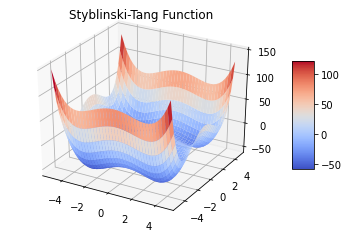

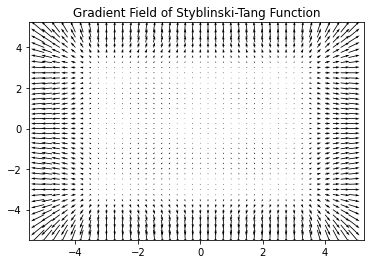

In [7]:
plotFunction(name = function, function = callable_function, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

plotGrad(name = grad, deriv_function = callable_function_deriv, 
         min_x = min_x, max_x = max_x, step_x = step_x, 
         min_y = min_y, max_y = max_y, step_y = step_y)

# **Data**

In [8]:
batch_samples = genData(
                        function = STFunction, 
                        deriv_function = STDeriv, 
                        dim_x = INPUT_DIM,
                        min_x = min_x, max_x = max_x, num_samples = nTrain
                )

x_train = [bs[0] for bs in batch_samples]
y_train = [bs[1] for bs in batch_samples]
dydx_train = [bs[2] for bs in batch_samples]

batch_samples = genData(
                        function = STFunction, 
                        deriv_function = STDeriv, 
                        dim_x = INPUT_DIM,
                        min_x = min_x, max_x = max_x, num_samples = nTest
                )

x_test = [bs[0] for bs in batch_samples]
y_test = [bs[1] for bs in batch_samples]
dydx_test = [bs[2] for bs in batch_samples]

stats_dic = {}

# **1) Normal Training**

In [9]:
name = "net"
with_derivative = False
key1 = "normal_training"
name_function = '%s %s' % (function, key1)
name_grad = '%s %s' % (grad, key1)
stats_dic[key1] = {}

## **1.1) with MLP**

In [10]:
model_class = MLP
key2 = "mlp"
stats_dic[key1][key2] = {}

### **1.1.1) normalize = False**

In [11]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 2190.5251826392505 train loss no scaled: 2190.5251826392505

Epoch 1: train loss: 2190.450993550712 train loss no scaled: 2190.450993550712





test loss: 1097.3442252499983 test loss no scaled 1097.3442252499983


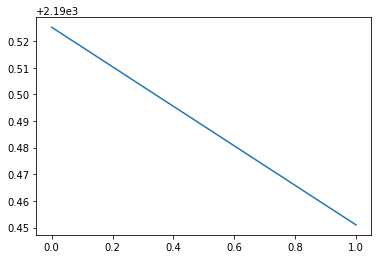

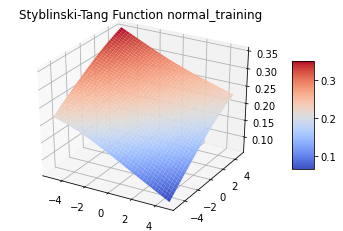

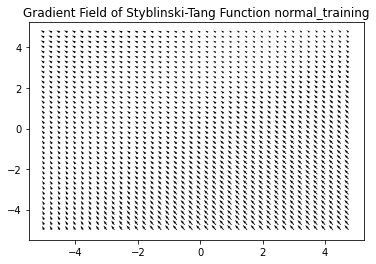

In [12]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 2190.63001181446 train loss no scaled: 2190.63001181446

Epoch 1: train loss: 2190.5338995809107 train loss no scaled: 2190.5338995809107





test loss: 1095.5776457529514 test loss no scaled 1095.5776457529514


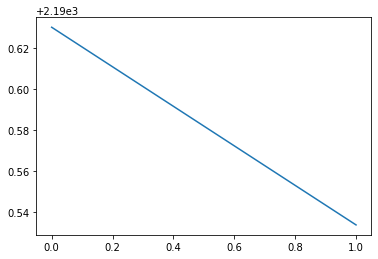

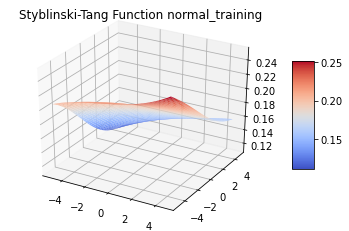

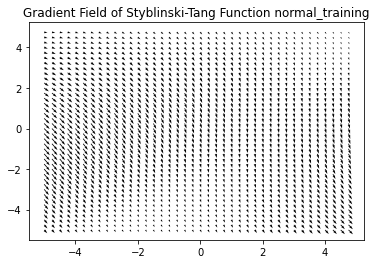

In [13]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = learning_rate_schedule
        )

### **1.1.2) normalize = True**

In [14]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 1.0938186199963094 train loss no scaled: 2381.91508392334

Epoch 1: train loss: 1.0868024292588234 train loss no scaled: 2366.6366680908204





test loss: 0.573128262758255 test loss no scaled 1248.0523596191406


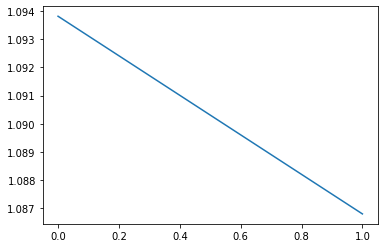

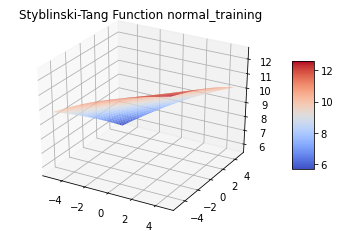

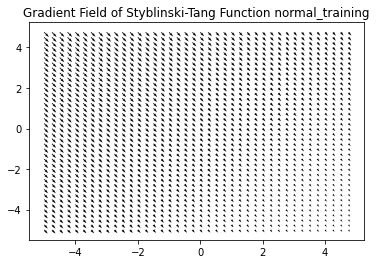

In [15]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 1.1318359956145287 train loss no scaled: 2464.7024267578126

Epoch 1: train loss: 1.122714850306511 train loss no scaled: 2444.839971313477





test loss: 0.6179879376292229 test loss no scaled 1345.7394622802735


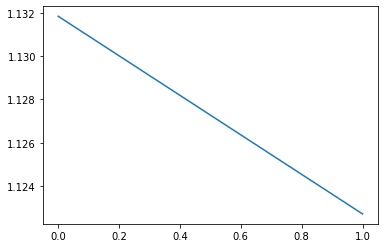

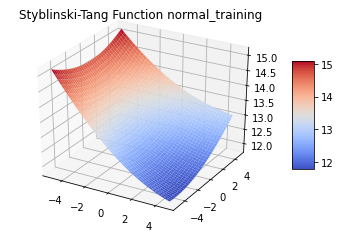

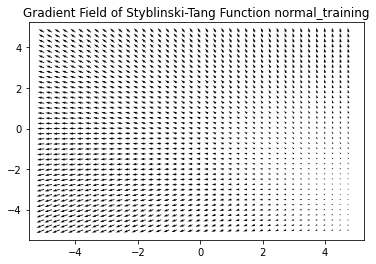

In [16]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = learning_rate_schedule
        )

## **1.2) with Siren**

In [17]:
model_class = Siren
key2 = "siren"
stats_dic[key1][key2] = {}

### **1.2.1) normalize = False**

In [18]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 2187.7633562350275 train loss no scaled: 2187.7633562350275

Epoch 1: train loss: 2187.1418681538107 train loss no scaled: 2187.1418681538107





test loss: 1095.3753774601523 test loss no scaled 1095.3753774601523


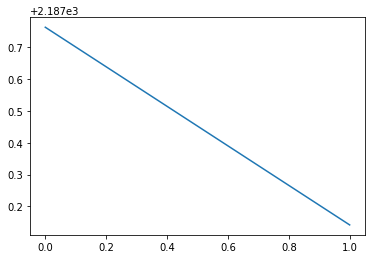

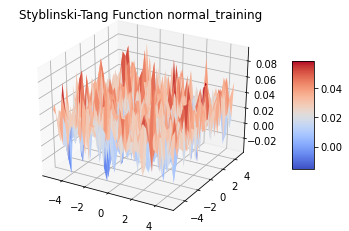

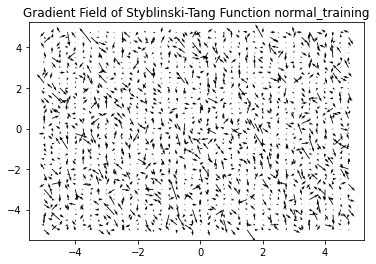

In [19]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 2187.551670075655 train loss no scaled: 2187.551670075655

Epoch 1: train loss: 2187.0409261289237 train loss no scaled: 2187.0409261289237





test loss: 1093.8283962934697 test loss no scaled 1093.8283962934697


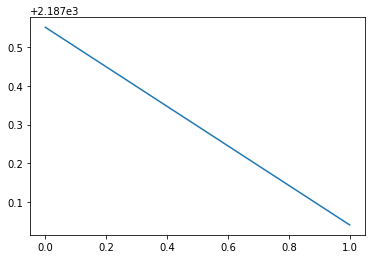

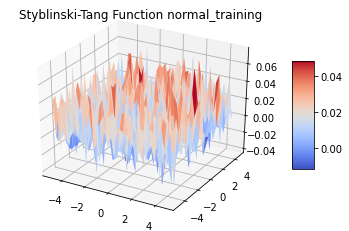

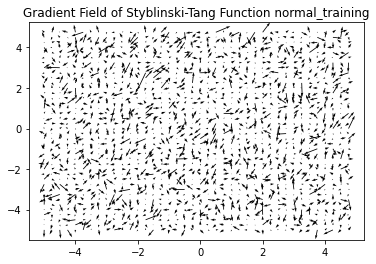

In [20]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = learning_rate_schedule
        )

### **1.2.2) normalize = True**

In [21]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 1.0295820674465108 train loss no scaled: 2242.032770035025

Epoch 1: train loss: 1.0185690792929996 train loss no scaled: 2218.050604872615





test loss: 0.5208203289049561 test loss no scaled 1134.1458111432194


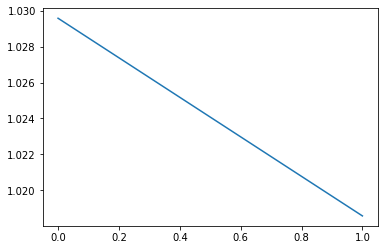

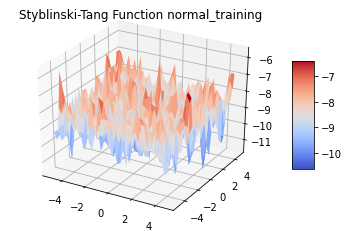

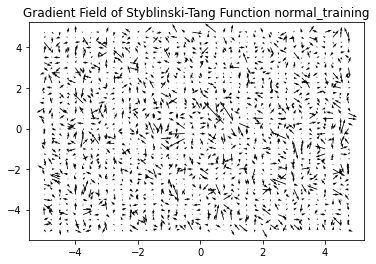

In [22]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 1.00039273926639 train loss no scaled: 2178.4697896027565

Epoch 1: train loss: 0.989988194773905 train loss no scaled: 2155.812562625408





test loss: 0.5072563757561147 test loss no scaled 1104.6087298250197


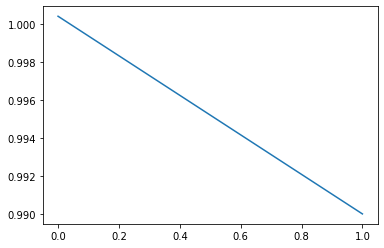

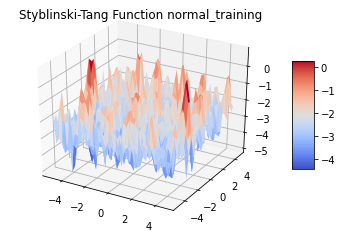

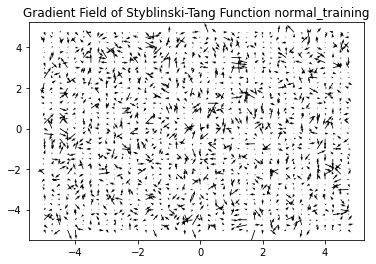

In [23]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = learning_rate_schedule
        )

# **2) Sobolev Training**

In [24]:
name = "net"
with_derivative = True
key1 = "sobolev_training"
name_function = '%s %s' % (function, key1)
name_grad = '%s %s' % (grad, key1)
stats_dic[key1] = {}

## **2.1) with MLP**

In [25]:
model_class = MLP
key2 = "mlp"
stats_dic[key1][key2] = {}

### **2.1.1) normalize = False**

In [26]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 4888.1357396697995, y loss : 2187.5174884432554, dy loss : 2700.618253288269

train loss no scaled: 4888.135741731525, y loss  no scaled : 2187.5174884432554, dy loss  no scaled: 2700.618253288269


Epoch 1: train loss: 4888.025035476685, y loss : 2187.4091416954993, dy loss : 2700.6158055496217

train loss no scaled: 4888.024947245121, y loss  no scaled : 2187.4091416954993, dy loss  no scaled: 2700.6158055496217






test loss: 4804.265264892578, y loss : 1093.534804598391, dydx loss : 3710.730347595215

test loss no scaled: 4804.265152193606, y loss  no scaled : 1093.534804598391, dydx loss  no scaled: 3710.730347595215




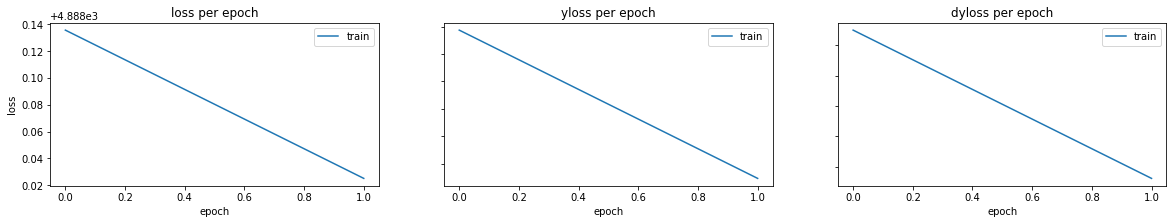

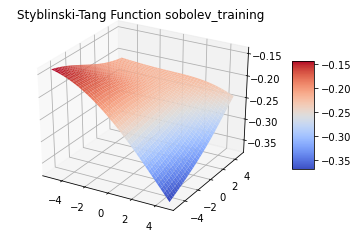

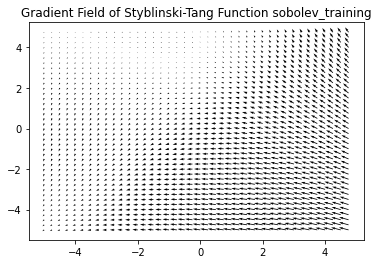

In [27]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 4888.74459526062, y loss : 2188.1994461667537, dy loss : 2700.545150680542

train loss no scaled: 4888.744596847296, y loss  no scaled : 2188.1994461667537, dy loss  no scaled: 2700.545150680542


Epoch 1: train loss: 4888.662760734558, y loss : 2188.116552087665, dy loss : 2700.5462815856936

train loss no scaled: 4888.662833673358, y loss  no scaled : 2188.116552087665, dy loss  no scaled: 2700.5462815856936






test loss: 4804.711558837891, y loss : 1094.8703628903656, dydx loss : 3709.841143798828

test loss no scaled: 4804.711506689194, y loss  no scaled : 1094.8703628903656, dydx loss  no scaled: 3709.841143798828




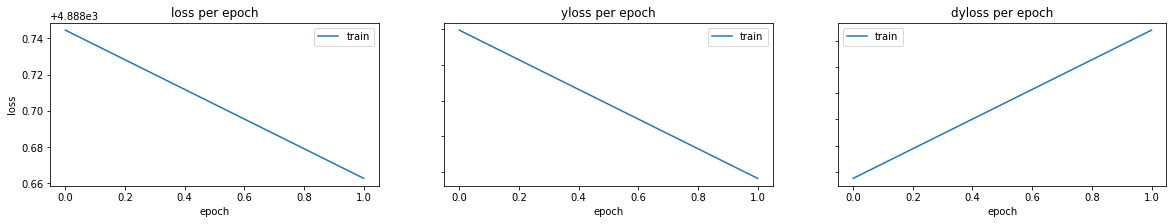

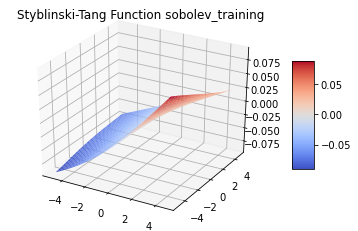

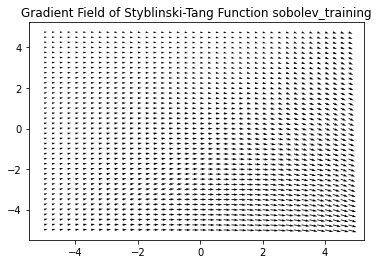

In [28]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = learning_rate_schedule
        )

### **2.1.2) normalize = True**

In [29]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 1.9949438409507274, y loss : 0.9955812962912023, dy loss : 0.9993625600636006

train loss no scaled: 4820.791639073481, y loss  no scaled : 2167.9922719192505, dy loss  no scaled: 2652.79936715423


Epoch 1: train loss: 1.9938539073616266, y loss : 0.9945046977885067, dy loss : 0.9993492779135704

train loss no scaled: 4818.385332804582, y loss  no scaled : 2165.647850341797, dy loss  no scaled: 2652.7374824627846






test loss: 2.1266809410659953, y loss : 0.49824471926178376, dydx loss : 1.628436221804211

test loss no scaled: 4749.681121711004, y loss  no scaled : 1084.9848008294402, dydx loss  no scaled: 3664.6963208815646




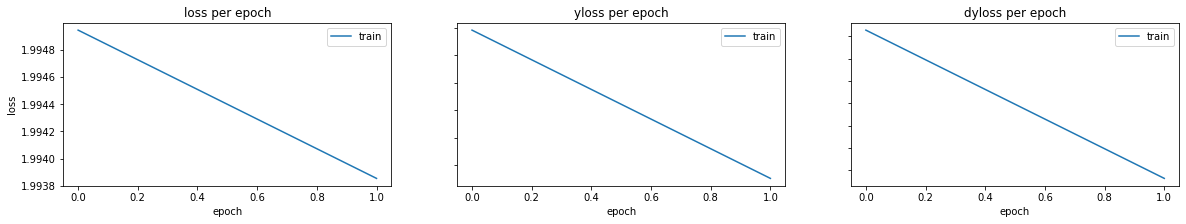

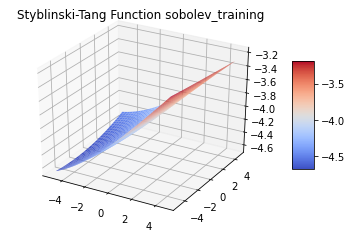

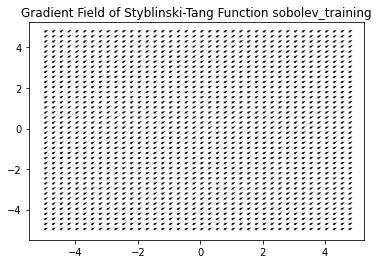

In [30]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(
          name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 2.0937116438150407, y loss : 1.093083243817091, dy loss : 1.0006284221261739

train loss no scaled: 5042.016510152071, y loss  no scaled : 2380.313865966797, dy loss  no scaled: 2661.7026441852736


Epoch 1: train loss: 2.085827506184578, y loss : 1.0850326837599278, dy loss : 1.000794806331396

train loss no scaled: 5024.9146858826925, y loss  no scaled : 2362.7827932739256, dy loss  no scaled: 2662.131892608767






test loss: 2.1957189087638067, y loss : 0.5788027286529541, dydx loss : 1.6169161801108525

test loss no scaled: 4905.283675419678, y loss  no scaled : 1260.4091302490235, dydx loss  no scaled: 3644.8745451706545




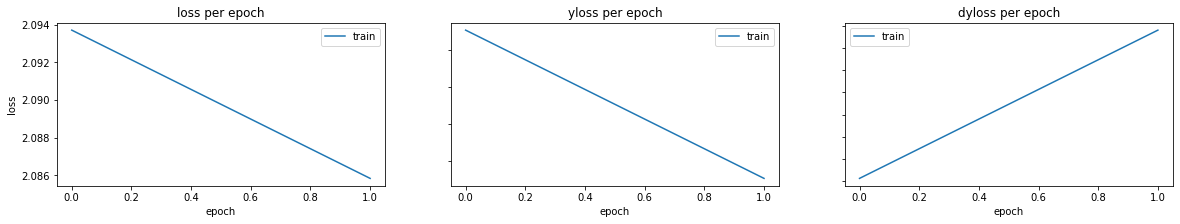

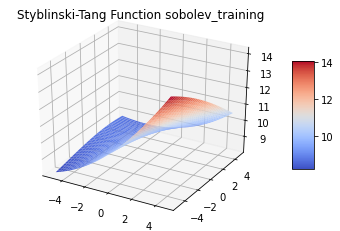

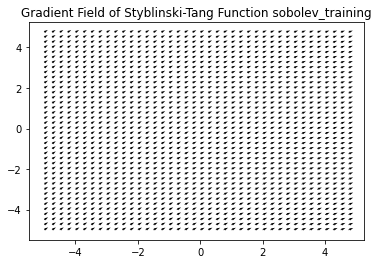

In [31]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(
          name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = learning_rate_schedule
        )

## **2.2) with Siren**

In [32]:
model_class = Siren
key2 = "siren"
stats_dic[key1][key2] = {}

### **2.2.1) normalize = False**

In [33]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 4883.9339635849, y loss : 2189.703539614156, dy loss : 2694.2303769302366

train loss no scaled: 4883.933916544393, y loss  no scaled : 2189.703539614156, dy loss  no scaled: 2694.2303769302366


Epoch 1: train loss: 4883.005755119324, y loss : 2189.263919431716, dy loss : 2693.741813659668

train loss no scaled: 4883.005733091384, y loss  no scaled : 2189.263919431716, dy loss  no scaled: 2693.741813659668






test loss: 4806.641616210937, y loss : 1097.0733076238632, dydx loss : 3709.568275146484

test loss no scaled: 4806.641582770348, y loss  no scaled : 1097.0733076238632, dydx loss  no scaled: 3709.568275146484




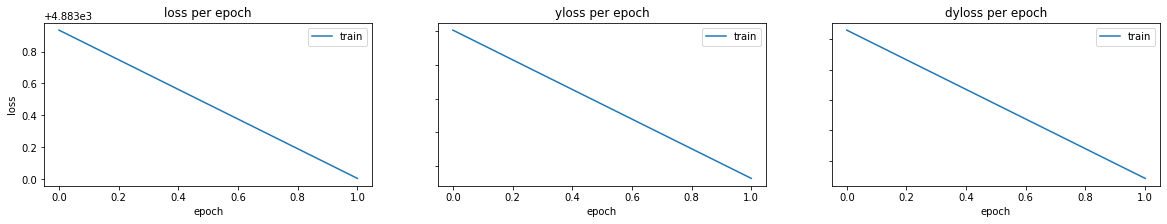

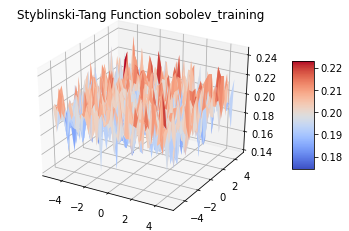

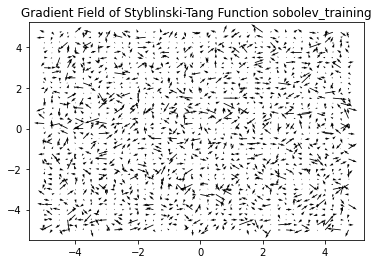

In [34]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 4883.657140655518, y loss : 2188.2757016968726, dy loss : 2695.3814896392823

train loss no scaled: 4883.657191336155, y loss  no scaled : 2188.2757016968726, dy loss  no scaled: 2695.3814896392823


Epoch 1: train loss: 4882.937177734375, y loss : 2187.7590039354563, dy loss : 2695.178250312805

train loss no scaled: 4882.9372542482615, y loss  no scaled : 2187.7590039354563, dy loss  no scaled: 2695.178250312805






test loss: 4810.973129882813, y loss : 1094.9282734603435, dydx loss : 3716.0448803710938

test loss no scaled: 4810.973153831437, y loss  no scaled : 1094.9282734603435, dydx loss  no scaled: 3716.0448803710938




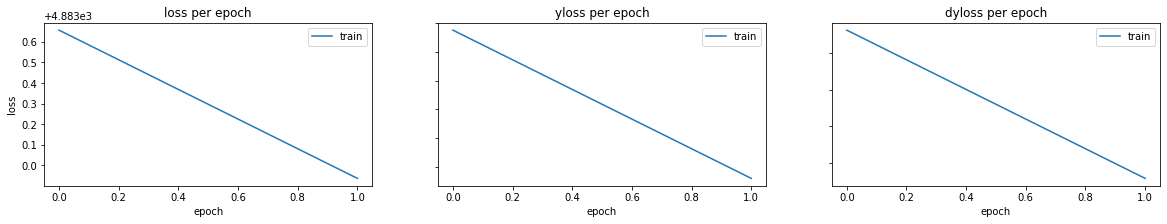

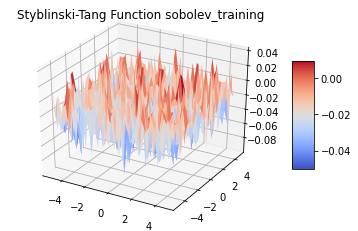

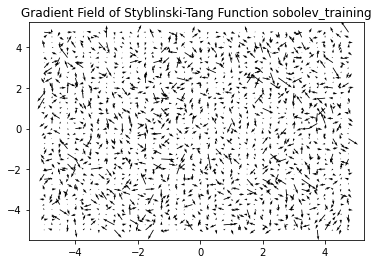

In [35]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = True, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = learning_rate_schedule
        )

### **2.2.2) normalize = True**

In [36]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 2.054981659948826, y loss : 1.022112245708704, dy loss : 1.0328694757819177

train loss no scaled: 4954.038838014829, y loss  no scaled : 2225.7664929962157, dy loss  no scaled: 2728.272345018613


Epoch 1: train loss: 2.0549849697947504, y loss : 1.0120304928533732, dy loss : 1.0429544693231583

train loss no scaled: 4965.139006913854, y loss  no scaled : 2203.8120388793945, dy loss  no scaled: 2761.3269680344592






test loss: 2.3608589961548847, y loss : 0.505193820213899, dydx loss : 1.8556651759409857

test loss no scaled: 5299.2336030188335, y loss  no scaled : 1100.1173160743713, dydx loss  no scaled: 4199.116286944462




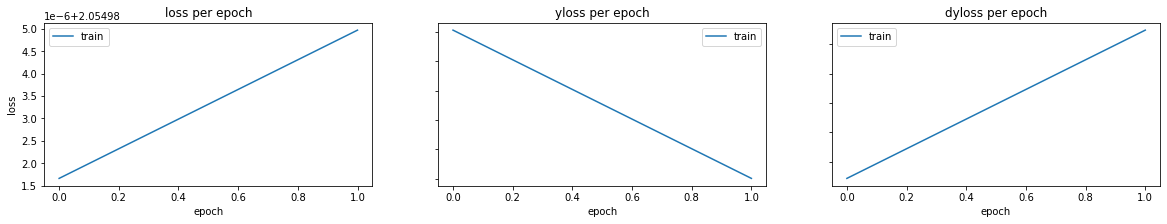

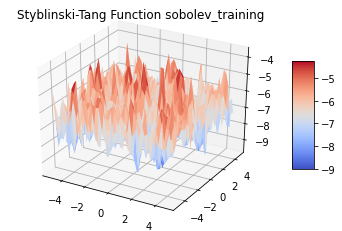

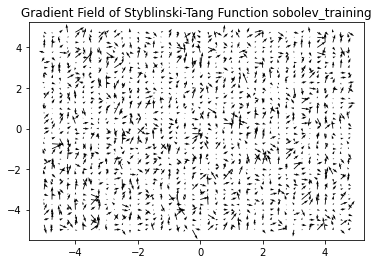

In [37]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 2.1789631593227385, y loss : 0.997919847695157, dy loss : 1.181043247282505

train loss no scaled: 5341.624505906306, y loss  no scaled : 2173.0846406173705, dy loss  no scaled: 3168.5398652889357


Epoch 1: train loss: 2.1653199972212316, y loss : 0.9881353346351535, dy loss : 1.1771846651285887

train loss no scaled: 5312.56785942341, y loss  no scaled : 2151.7778384590147, dy loss  no scaled: 3160.790020964395






test loss: 2.115813707976019, y loss : 0.5042845545183036, dydx loss : 1.6115291534577154

test loss no scaled: 4722.415221821435, y loss  no scaled : 1098.1373031461983, dydx loss  no scaled: 3624.277918675237




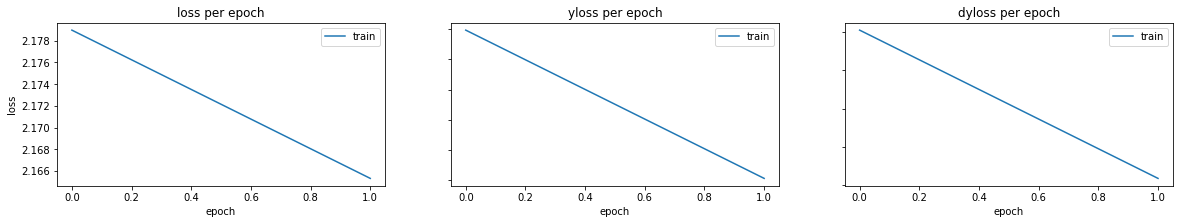

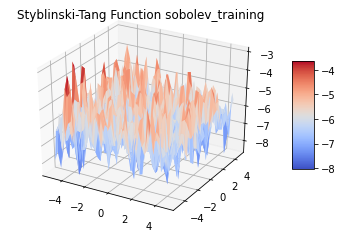

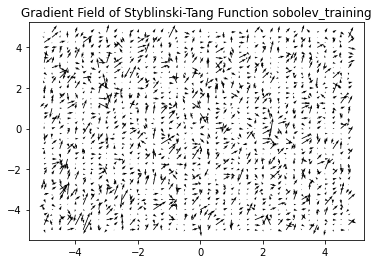

In [38]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = learning_rate_schedule
        )

# **3) twin_net tensorflow**

In [39]:
generator = Generator(callable_function = callable_function, 
                      callable_function_deriv = callable_function_deriv, 
                      dim_x = INPUT_DIM,
                      min_x = min_x, max_x = max_x)

key1 = "twin_net_tf"
name_function = '%s %s' % (function, key1)
name_grad = '%s %s' % (grad, key1)
stats_dic[key1] = {}

## **3.1) with MLP**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 25


Epoch 0: y loss : 7177.34326171875, dy loss : 62.592247009277344
Epoch 1: y loss : 197.98460388183594, dy loss : 24.49014663696289

test y loss : 1840.41357421875, test dy loss : 2964.9951171875


Epoch 0: y loss : 7177.34326171875, dy loss : 62.592247009277344
Epoch 1: y loss : 200.69566345214844, dy loss : 24.480209350585938

test y loss : 1836.6365966796875, test dy loss : 2963.014892578125


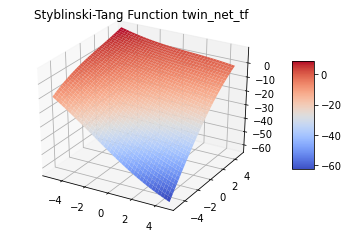

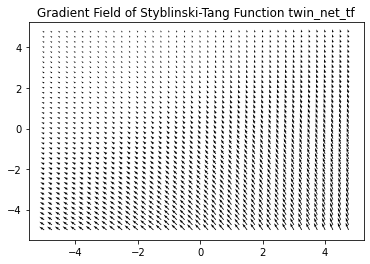

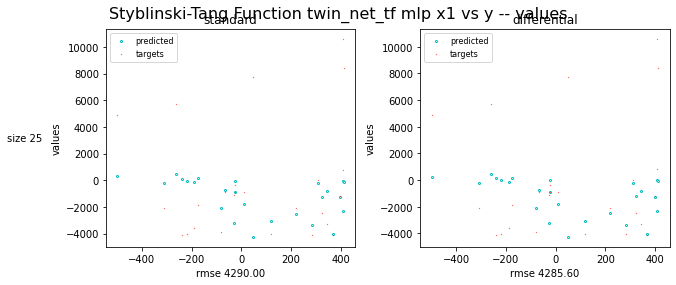

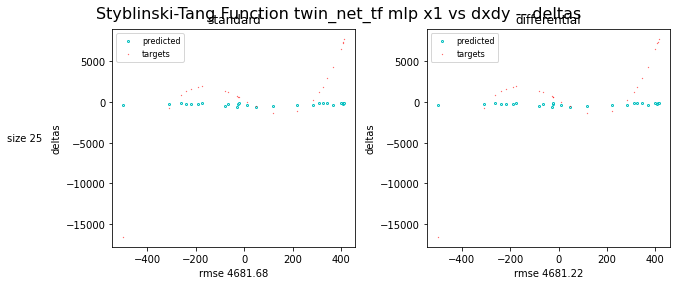

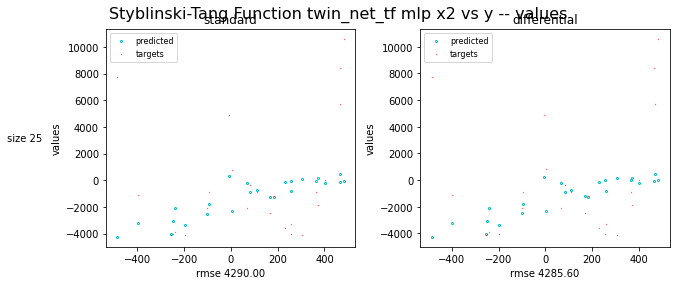

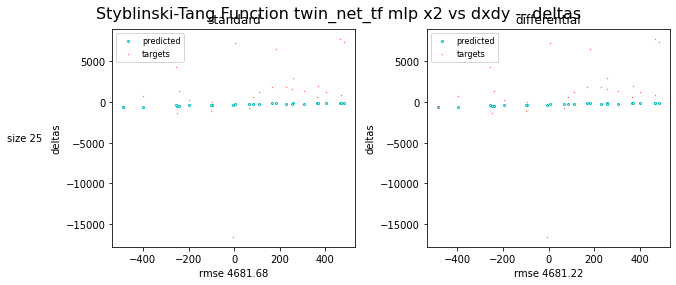

In [40]:
key2 = "mlp"
stats_dic[key1][key2] = {}
graph_name = "%s %s" % (name_function, key2)
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad)
stats_dic[key1][key2]["differential"] = regressor.stats["differential"]
stats_dic[key1][key2]["normal"] = regressor.stats["normal"]

## **3.2) with Siren**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 25


Epoch 0: y loss : 838.497314453125, dy loss : 18187.994140625
Epoch 1: y loss : 22331.6640625, dy loss : 1247416.625

test y loss : 15035.767578125, test dy loss : 1740047.625


Epoch 0: y loss : 838.4971923828125, dy loss : 18187.91796875
Epoch 1: y loss : 8707.6689453125, dy loss : 1176466.125

test y loss : 16534.9609375, test dy loss : 2208667.25


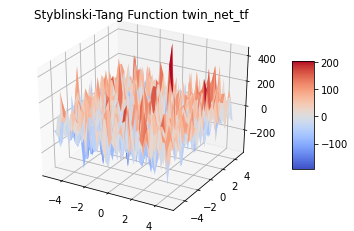

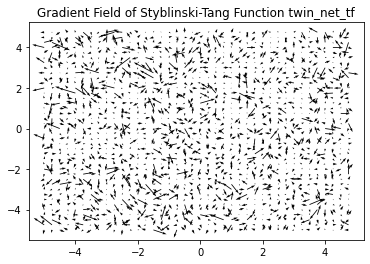

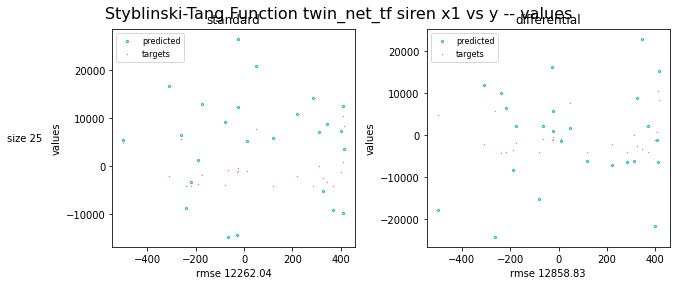

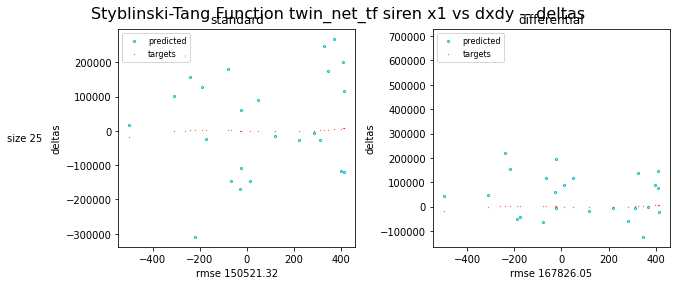

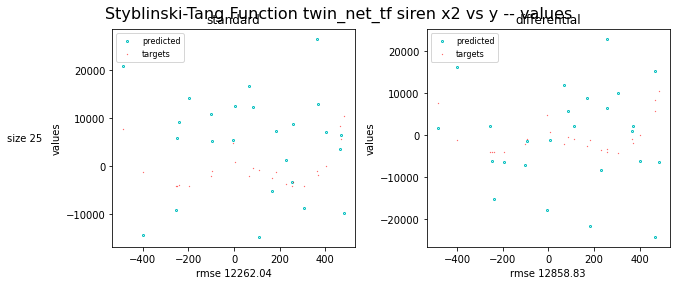

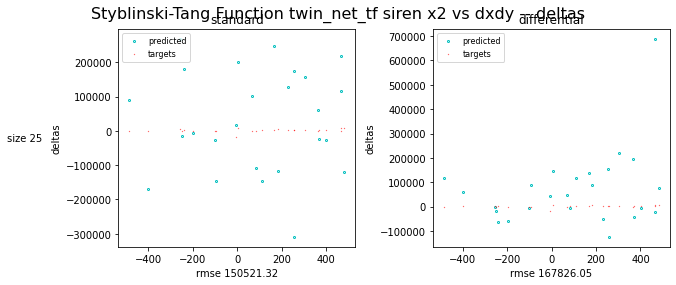

In [41]:
key2 = "siren"
stats_dic[key1][key2] = {}
graph_name = "%s %s" % (name_function, key2)
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad, siren = True)
stats_dic[key1][key2]["differential"] = regressor.stats["differential"]
stats_dic[key1][key2]["normal"] = regressor.stats["normal"]

# **4) twin_net pytorch**

In [42]:
name = "twin_net"
with_derivative = True
key1 = "twin_net_pytorch"
name_function = '%s %s' % (function, key1)
name_grad = '%s %s' % (grad, key1)
stats_dic[key1] = {}

## **4.1) with MLP**

In [43]:
model_class = MLP
key2 = "mlp"
stats_dic[key1][key2] = {}

### **4.1.1) normalize = False**

In [44]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 4885.692463760376, y loss : 2185.3736680773413, dy loss : 2700.318724746704

train loss no scaled: 4885.692392824045, y loss  no scaled : 2185.3736680773413, dy loss  no scaled: 2700.318724746704


Epoch 1: train loss: 4885.581181526184, y loss : 2185.2695406418457, dy loss : 2700.3117493057252

train loss no scaled: 4885.581289947571, y loss  no scaled : 2185.2695406418457, dy loss  no scaled: 2700.3117493057252






test loss: 4802.07828125, y loss : 1092.57608142972, dydx loss : 3709.502222595215

test loss no scaled: 4802.078304024935, y loss  no scaled : 1092.57608142972, dydx loss  no scaled: 3709.502222595215




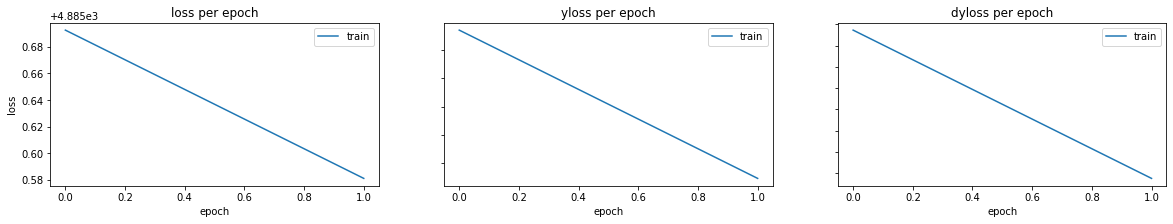

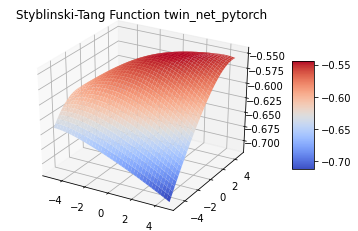

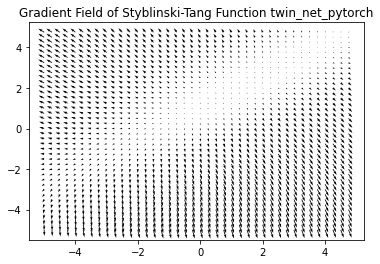

In [45]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(
          name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = True, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 4888.720013656616, y loss : 2188.3106443000584, dy loss : 2700.409247589111

train loss no scaled: 4888.71989188917, y loss  no scaled : 2188.3106443000584, dy loss  no scaled: 2700.409247589111


Epoch 1: train loss: 4888.614506607056, y loss : 2188.206309237704, dy loss : 2700.408338508606

train loss no scaled: 4888.61464774631, y loss  no scaled : 2188.206309237704, dy loss  no scaled: 2700.408338508606






test loss: 4802.59883178711, y loss : 1092.7547068524361, dydx loss : 3709.844099731445

test loss no scaled: 4802.598806583881, y loss  no scaled : 1092.7547068524361, dydx loss  no scaled: 3709.844099731445




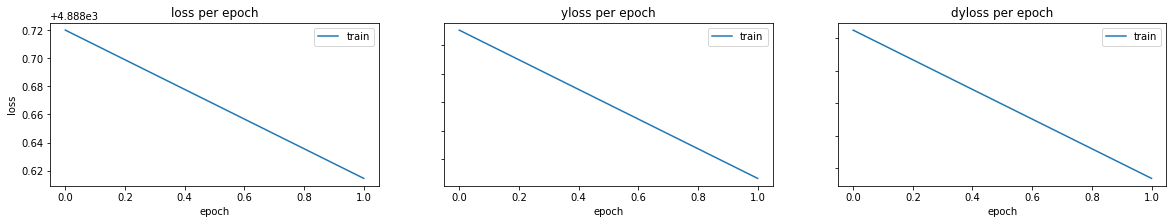

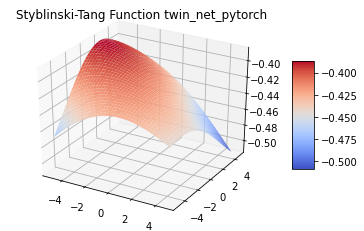

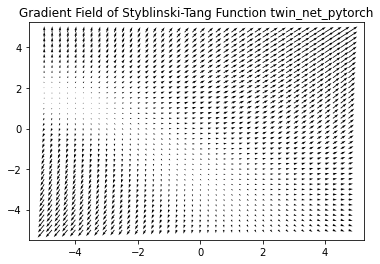

In [46]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(
          name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = True, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = learning_rate_schedule
        )

### **4.1.2) normalize = True**

In [47]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 2.2151356959342956, y loss : 1.213722785115242, dy loss : 1.0014128674566747

train loss no scaled: 5300.84672687975, y loss  no scaled : 2643.0202935791017, dy loss  no scaled: 2657.826433300649


Epoch 1: train loss: 2.203900843858719, y loss : 1.2024866247177124, dy loss : 1.001414217352867

train loss no scaled: 5276.3723834805605, y loss  no scaled : 2618.552158203125, dy loss  no scaled: 2657.820225277436






test loss: 2.33644395707159, y loss : 0.700359331779182, dydx loss : 1.636084625292408

test loss no scaled: 5207.730380411791, y loss  no scaled : 1525.1125868225097, dydx loss  no scaled: 3682.6177935892815




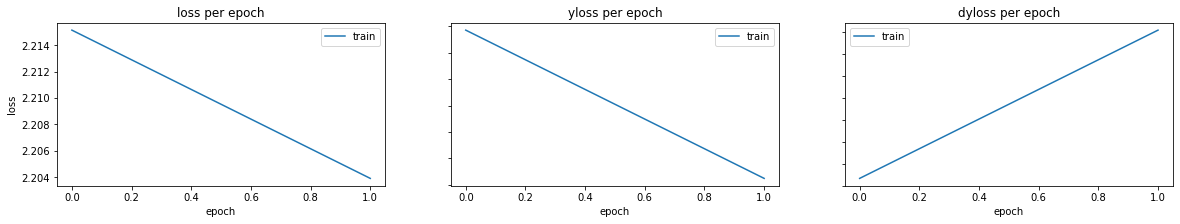

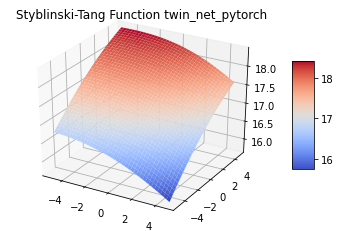

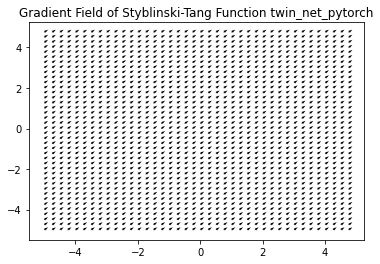

In [48]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(
          name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 2.74243034362793, y loss : 1.7488628520071507, dy loss : 0.9935674919188022

train loss no scaled: 6447.940633462233, y loss  no scaled : 3808.3486745452883, dy loss  no scaled: 2639.591958916944


Epoch 1: train loss: 2.705841864347458, y loss : 1.7116983460076154, dy loss : 0.9941434939950704

train loss no scaled: 6368.372844613134, y loss  no scaled : 3727.4190321731567, dy loss  no scaled: 2640.9538124399774






test loss: 2.7797224485812135, y loss : 1.151769557064399, dydx loss : 1.6279528915168149

test loss no scaled: 6174.997431859412, y loss  no scaled : 2508.1099098014834, dydx loss  no scaled: 3666.8875220579293




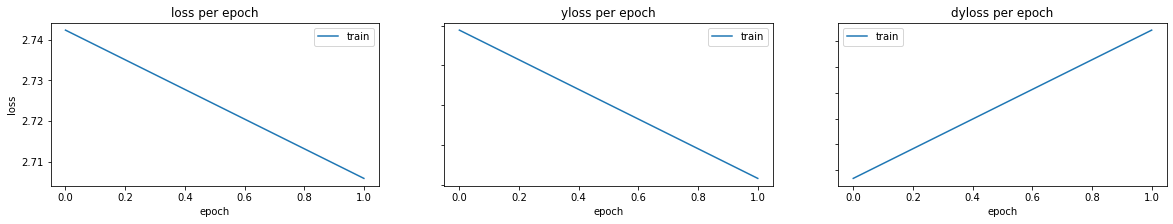

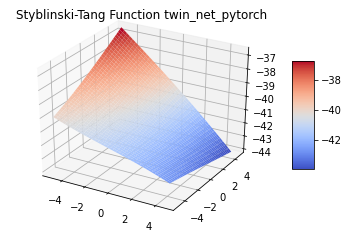

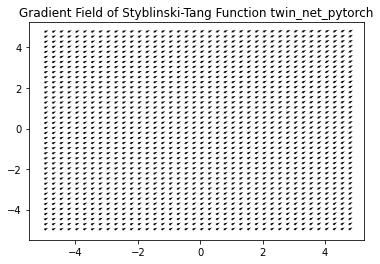

In [49]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = learning_rate_schedule
        )

## **4.2) with Siren**

In [50]:
model_class = Siren
key2 = "siren"
stats_dic[key1][key2] = {}

### **4.2.1) normalize = False**

In [51]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 4878.858216133118, y loss : 2188.143089233637, dy loss : 2690.7151027679442

train loss no scaled: 4878.858192001581, y loss  no scaled : 2188.143089233637, dy loss  no scaled: 2690.7151027679442


Epoch 1: train loss: 4879.2297541809085, y loss : 2187.410460745692, dy loss : 2691.8192190933228

train loss no scaled: 4879.229679839014, y loss  no scaled : 2187.410460745692, dy loss  no scaled: 2691.8192190933228






test loss: 4797.948117675781, y loss : 1094.0355967499502, dydx loss : 3703.9125592041014

test loss no scaled: 4797.948155954052, y loss  no scaled : 1094.0355967499502, dydx loss  no scaled: 3703.9125592041014




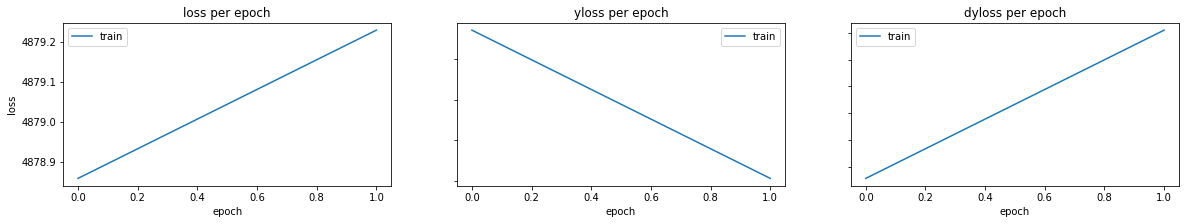

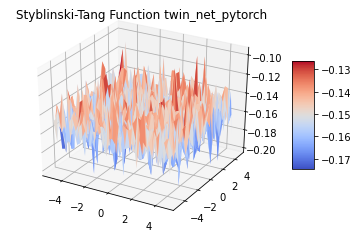

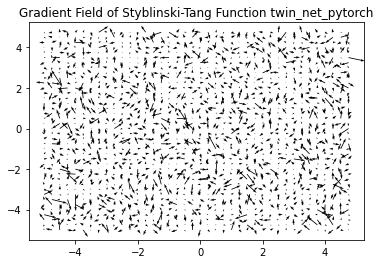

In [52]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = True, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 4883.1874487686155, y loss : 2190.2231553987413, dy loss : 2692.9643130874633

train loss no scaled: 4883.187468486205, y loss  no scaled : 2190.2231553987413, dy loss  no scaled: 2692.9643130874633


Epoch 1: train loss: 4880.8199570465085, y loss : 2189.6757714371383, dy loss : 2691.14413646698

train loss no scaled: 4880.819907904119, y loss  no scaled : 2189.6757714371383, dy loss  no scaled: 2691.14413646698






test loss: 4816.732980957031, y loss : 1096.3215397133679, dydx loss : 3720.411475830078

test loss no scaled: 4816.733015543446, y loss  no scaled : 1096.3215397133679, dydx loss  no scaled: 3720.411475830078




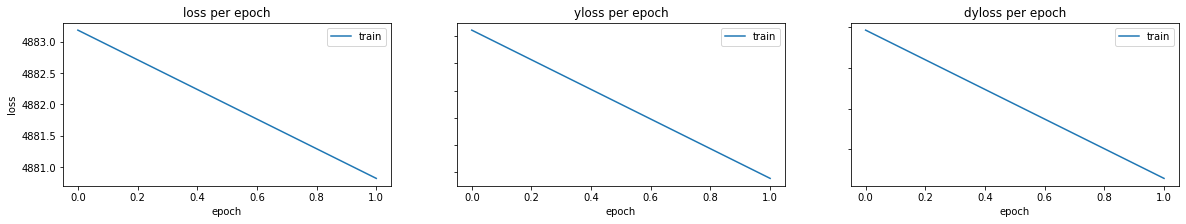

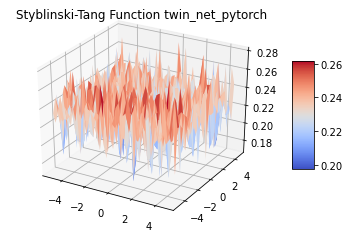

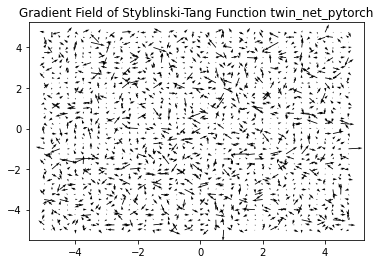

In [53]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = True, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = learning_rate_schedule
        )

### **4.2.2) normalize = True**

In [54]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 2.0796007558703424, y loss : 1.0087221391964705, dy loss : 1.0708786784484983

train loss no scaled: 4918.958467656174, y loss  no scaled : 2196.6079054117204, dy loss  no scaled: 2722.350562244454


Epoch 1: train loss: 2.0568156746029853, y loss : 0.9994647110626101, dy loss : 1.0573509807512165

train loss no scaled: 4862.900137257806, y loss  no scaled : 2176.4486597871783, dy loss  no scaled: 2686.451477470627






test loss: 2.3480156893505257, y loss : 0.5224337069899775, dydx loss : 1.8255819823605481

test loss no scaled: 5271.208765857365, y loss  no scaled : 1137.6591885995865, dydx loss  no scaled: 4133.549577257778




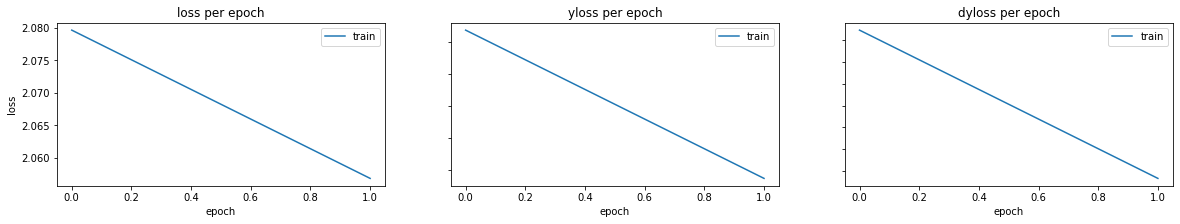

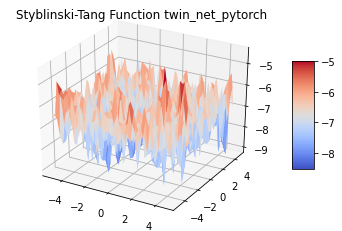

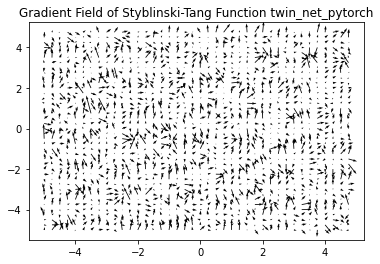

In [55]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 2.0807824221253397, y loss : 1.0437007160112262, dy loss : 1.0370816835947334

train loss no scaled: 5089.052817375437, y loss  no scaled : 2272.777596740723, dy loss  no scaled: 2816.275220634715


Epoch 1: train loss: 2.074883255660534, y loss : 1.0354313562065363, dy loss : 1.0394519028812648

train loss no scaled: 5077.9581665434725, y loss  no scaled : 2254.770249404907, dy loss  no scaled: 2823.187917138565






test loss: 2.2512909717925482, y loss : 0.519010367966257, dydx loss : 1.7322806038262915

test loss no scaled: 5044.482917588111, y loss  no scaled : 1130.2044817447663, dydx loss  no scaled: 3914.2784358433455




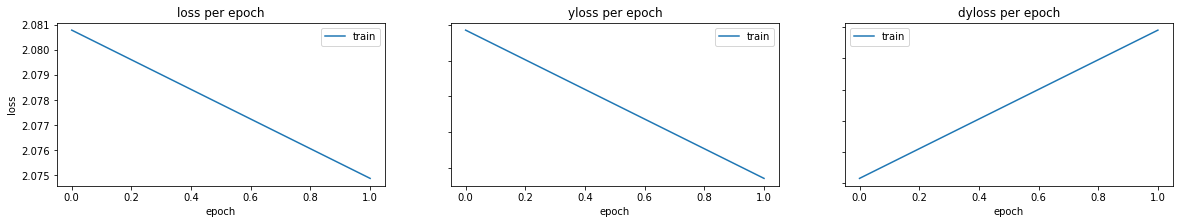

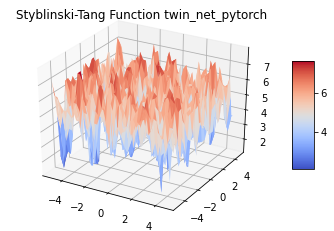

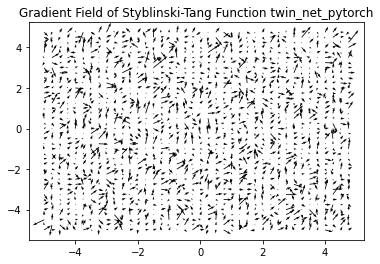

In [56]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = learning_rate_schedule
        )

# **5) Global Stats**

In [57]:
global_stat(stats_dic, suptitle = function)

{'normal_training': {'mlp': {'no_normalize': [{'train_loss': [2190.63001181446, 2190.5338995809107]}, None], 'normalize': [{'train_loss': [1.0938186199963094, 1.0868024292588234]}, {'train_loss': [1.1318359956145287, 1.122714850306511]}]}, 'siren': {'no_normalize': [{'train_loss': [2187.7633562350275, 2187.1418681538107]}, {'train_loss': [2187.551670075655, 2187.0409261289237]}], 'normalize': [{'train_loss': [1.0295820674465108, 1.0185690792929996]}, {'train_loss': [1.00039273926639, 0.989988194773905]}]}}, 'sobolev_training': {'mlp': {'no_normalize': [{'train_loss': [4888.74459526062, 4888.662760734558], 'train_yloss': [2188.1994461667537, 2188.116552087665], 'train_dyloss': [2700.545150680542, 2700.5462815856936]}, None], 'normalize': [{'train_loss': [1.9949438409507274, 1.9938539073616266], 'train_yloss': [0.9955812962912023, 0.9945046977885067], 'train_dyloss': [0.9993625600636006, 0.9993492779135704]}, {'train_loss': [2.0937116438150407, 2.085827506184578], 'train_yloss': [1.09308